In [1]:
!pip install -q torchmetrics[image]

In [14]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator
from torchmetrics.image.fid import FrechetInceptionDistance
import glob
import matplotlib.pyplot as plt

In [6]:
def normalize_neg_one_to_one(img):
    return img * 2 - 1

class LocalDataset(Dataset):
    def __init__(self, folder, image_size, exts=['png', 'jpg', 'jpeg']):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.paths = []
        for ext in exts:
            self.paths.extend([
                p for p in Path(folder).rglob(f'*.{ext}')
                if p.suffix.lower() == f'.{ext.lower()}'
            ])
        
        if len(self.paths) == 0:
            print(f"WARNING: No images found in {folder}")

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.Grayscale(), 
            T.ToTensor(),
            T.Lambda(normalize_neg_one_to_one),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path).convert('L') 
        return self.transform(img)

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate_with_fid(config, epoch, pipeline, real_dataloader, device):
    fid = FrechetInceptionDistance(feature=64).to(device)
    
    real_batch = next(iter(real_dataloader))
    real_imgs = (real_batch / 2 + 0.5).clamp(0, 1) 
    real_imgs = (real_imgs * 255).to(torch.uint8).to(device)
    if real_imgs.shape[1] == 1: real_imgs = real_imgs.repeat(1, 3, 1, 1) 
    fid.update(real_imgs, real=True)

    images = pipeline(
        batch_size=config['eval_batch_size'], 
        num_inference_steps=50, 
        output_type="numpy"
    ).images
    
    fake_tensors = torch.tensor(images).permute(0, 3, 1, 2)
    fake_tensors = (fake_tensors * 255).to(torch.uint8).to(device)
    if fake_tensors.shape[1] == 1: fake_tensors = fake_tensors.repeat(1, 3, 1, 1) 
    fid.update(fake_tensors, real=False)

    score = fid.compute().item()
    print(f"Epoch {epoch} | FID Score: {score:.4f} ")
    
    pil_images = pipeline.numpy_to_pil(images)
    image_grid = make_grid(pil_images, rows=4, cols=4)
    test_dir = os.path.join(config['output_dir'], "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}_fid_{score:.2f}.png")

In [7]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config['mixed_precision'],
        gradient_accumulation_steps=config['gradient_accumulation_steps'],
        project_dir=os.path.join(config['output_dir'], "logs")
    )

    if accelerator.is_main_process:
        os.makedirs(config['output_dir'], exist_ok=True)

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config['num_epochs']):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.detach().item())
            global_step += 1

        if accelerator.is_main_process:
            if (epoch + 1) % config['save_image_epochs'] == 0 or epoch == config['num_epochs'] - 1:
                pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
                
                evaluate_with_fid(config, epoch, pipeline, train_dataloader, accelerator.device)
                
                save_dir = os.path.join(config['output_dir'], f"epoch{epoch}")
                pipeline.save_pretrained(save_dir)

# 100% DATA  

In [10]:
config = {
    "data_path": "/kaggle/input/sanskrit-devanagari-graphemes/sanskrit_dataset", 
    "image_size": 64,          
    "train_batch_size": 64,
    "eval_batch_size": 16,
    "num_epochs": 20,
    "gradient_accumulation_steps": 1,
    "learning_rate": 1e-4,
    "lr_warmup_steps": 500,
    "save_image_epochs": 4,    
    "mixed_precision": "fp16",
    "output_dir": "diffusion",
    "seed": 42
}

dataset = LocalDataset(config['data_path'], image_size=config['image_size'])
train_dataloader = DataLoader(dataset, batch_size=config['train_batch_size'], shuffle=True)

model = UNet2DModel(
    sample_size=config['image_size'],
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = AdamW(model.parameters(), lr=config['learning_rate'])
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config['lr_warmup_steps'],
    num_training_steps=(len(train_dataloader) * config['num_epochs']),
)

In [11]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth





  0%|          | 0.00/91.2M [00:00<?, ?B/s]




 15%|█▌        | 13.8M/91.2M [00:00<00:00, 143MB/s]




 56%|█████▌    | 50.9M/91.2M [00:00<00:00, 288MB/s]




100%|██████████| 91.2M/91.2M [00:00<00:00, 308MB/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 | FID Score: 19.4705 


  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 | FID Score: 0.0484 


  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11 | FID Score: 0.0279 


  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15 | FID Score: 0.0113 


  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19 | FID Score: 0.0148 


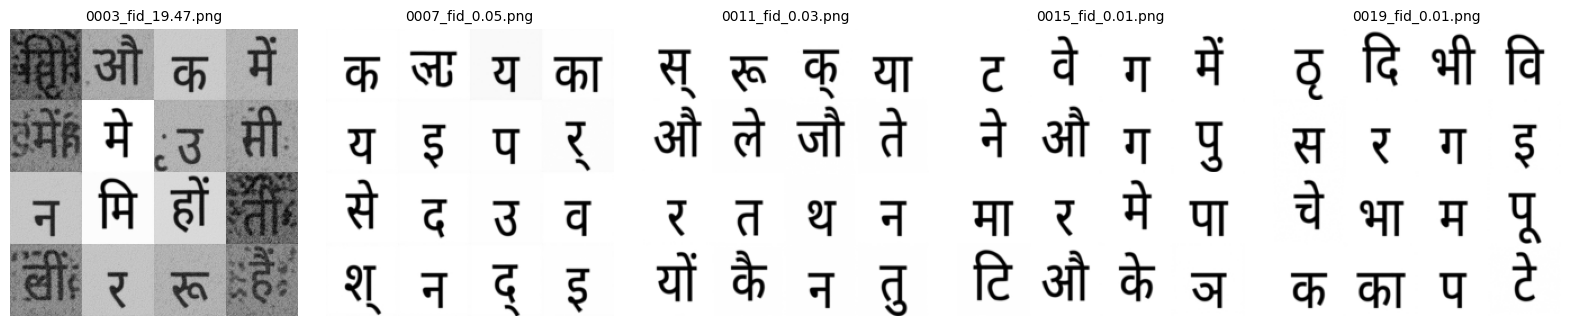

In [15]:
folder = "/kaggle/working/diffusion/samples"
images = sorted(glob.glob(f"{folder}/*.png"))

plt.figure(figsize=(20, 6)) 
plt.subplots_adjust(wspace=0.1) 

for i, img_path in enumerate(images):
    img = Image.open(img_path)
    plt.subplot(1, len(images), i+1) 
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=10) 
    plt.axis("off")

plt.show()

# 1 PERCENT #  

In [20]:
config = {
    "data_path": "/kaggle/input/splits/1percent", # <--- UPDATE THIS
    "image_size": 64,          # Suggest 64 for testing, 128 if you have time
    "train_batch_size": 64,
    "eval_batch_size": 16,
    "num_epochs": 150,
    "gradient_accumulation_steps": 1,
    "learning_rate": 1e-4,
    "lr_warmup_steps": 500,
    "save_image_epochs": 15,    # Evaluate every 5 epochs
    "mixed_precision": "fp16",
    "output_dir": "diffusion_1",
    "seed": 42
}

dataset = LocalDataset(config['data_path'], image_size=config['image_size'])
train_dataloader = DataLoader(dataset, batch_size=config['train_batch_size'], shuffle=True)

model = UNet2DModel(
    sample_size=config['image_size'],
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)


noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = AdamW(model.parameters(), lr=config['learning_rate'])
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config['lr_warmup_steps'],
    num_training_steps=(len(train_dataloader) * config['num_epochs']),
)

In [21]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14 | FID Score: 28.1208 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29 | FID Score: 25.6444 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44 | FID Score: 30.4444 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 59 | FID Score: 44.1025 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 74 | FID Score: 15.0201 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 89 | FID Score: 30.8076 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 104 | FID Score: 19.8516 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 119 | FID Score: 23.4855 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 134 | FID Score: 17.2585 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 149 | FID Score: 29.2965 


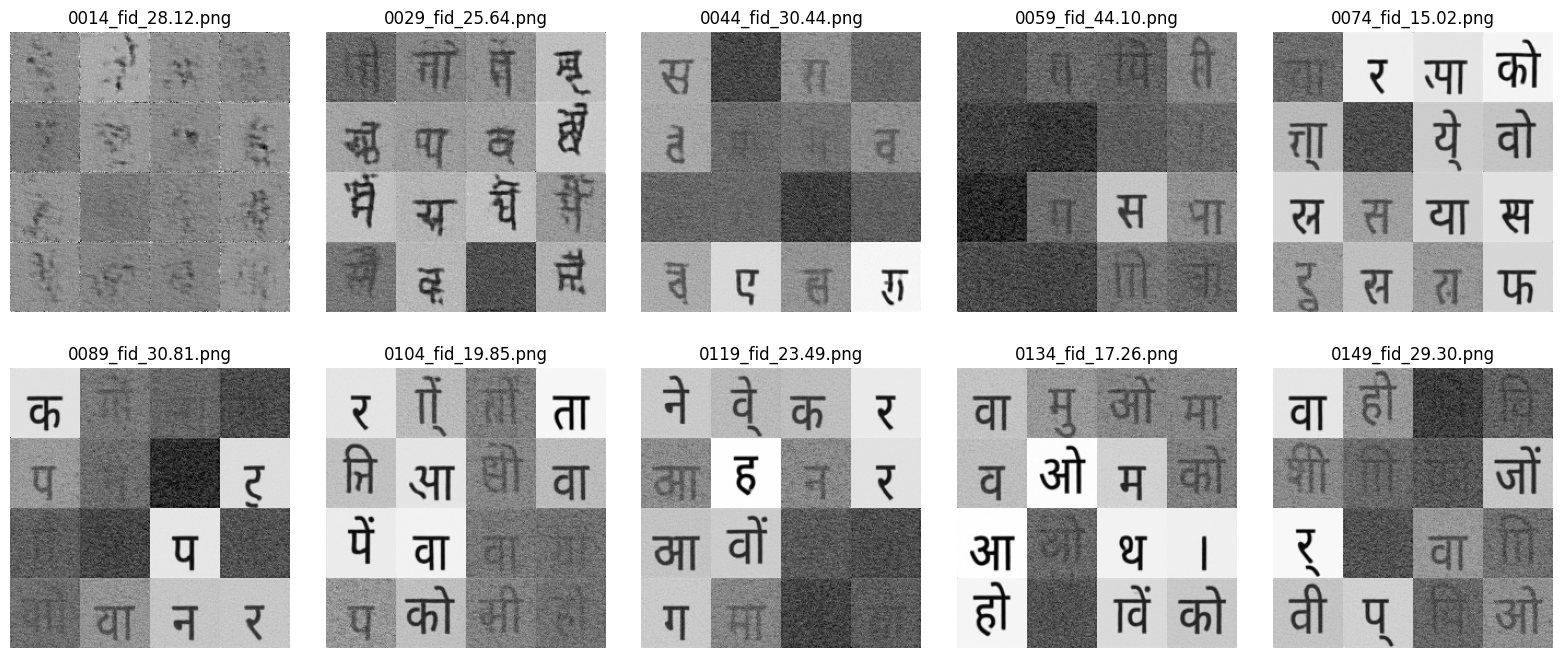

In [22]:
folder = "/kaggle/working/diffusion_1/samples"
images = sorted(glob.glob(f"{folder}/*.png"))
 
plt.figure(figsize=(20, 8)) 
plt.subplots_adjust(wspace=0.1, hspace=0.2) 

for i, img_path in enumerate(images):
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1) 
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12) 
    plt.axis("off")

plt.show()

#  25 PERCENT # 

In [23]:
config = {
    "data_path": "/kaggle/input/splits/25percent", # <--- UPDATE THIS
    "image_size": 64,          # Suggest 64 for testing, 128 if you have time
    "train_batch_size": 64,
    "eval_batch_size": 16,
    "num_epochs": 80,
    "gradient_accumulation_steps": 1,
    "learning_rate": 1e-4,
    "lr_warmup_steps": 500,
    "save_image_epochs": 8,    # Evaluate every 5 epochs
    "mixed_precision": "fp16",
    "output_dir": "diffusion_25",
    "seed": 42
}

dataset = LocalDataset(config['data_path'], image_size=config['image_size'])
train_dataloader = DataLoader(dataset, batch_size=config['train_batch_size'], shuffle=True)

model = UNet2DModel(
    sample_size=config['image_size'],
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)


noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = AdamW(model.parameters(), lr=config['learning_rate'])
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config['lr_warmup_steps'],
    num_training_steps=(len(train_dataloader) * config['num_epochs']),
)

In [24]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 | FID Score: 8.5478 


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15 | FID Score: 8.1397 


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23 | FID Score: 0.5686 


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31 | FID Score: 0.0626 


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39 | FID Score: 0.0128 


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47 | FID Score: 0.0298 


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 55 | FID Score: 0.0179 


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 63 | FID Score: 0.0278 


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 71 | FID Score: 0.0402 


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 79 | FID Score: 0.0241 


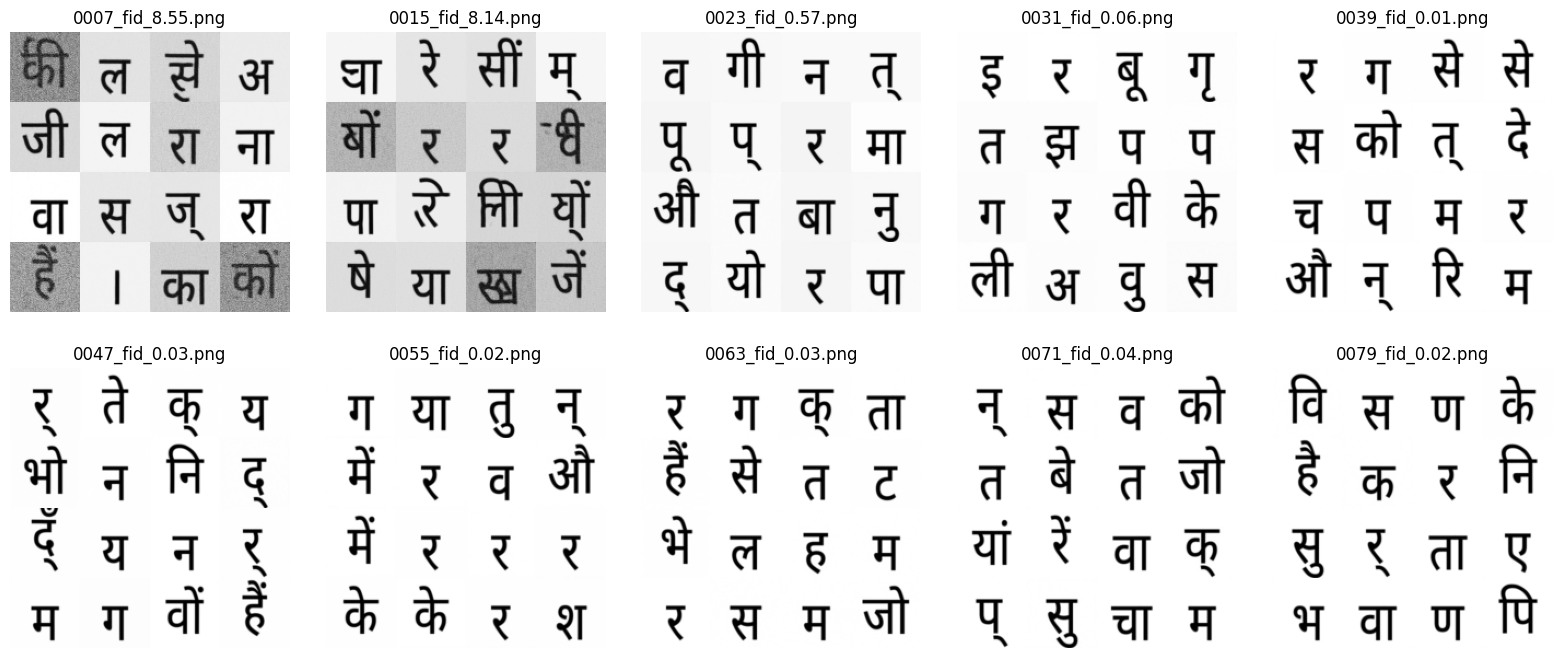

In [25]:
folder = "/kaggle/working/diffusion_25/samples"
images = sorted(glob.glob(f"{folder}/*.png"))
 
plt.figure(figsize=(20, 8)) 
plt.subplots_adjust(wspace=0.1, hspace=0.2) 

for i, img_path in enumerate(images):
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1) 
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12) 
    plt.axis("off")

plt.show()

# # 50 PERCENT 

In [26]:
config = {
    "data_path": "/kaggle/input/splits/50percent", # <--- UPDATE THIS
    "image_size": 64,          # Suggest 64 for testing, 128 if you have time
    "train_batch_size": 64,
    "eval_batch_size": 16,
    "num_epochs": 40,
    "gradient_accumulation_steps": 1,
    "learning_rate": 1e-4,
    "lr_warmup_steps": 500,
    "save_image_epochs": 4,    # Evaluate every 5 epochs
    "mixed_precision": "fp16",
    "output_dir": "diffusion_50",
    "seed": 42
}


dataset = LocalDataset(config['data_path'], image_size=config['image_size'])
train_dataloader = DataLoader(dataset, batch_size=config['train_batch_size'], shuffle=True)

model = UNet2DModel(
    sample_size=config['image_size'],
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)


noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = AdamW(model.parameters(), lr=config['learning_rate'])
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config['lr_warmup_steps'],
    num_training_steps=(len(train_dataloader) * config['num_epochs']),
)

In [27]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 | FID Score: 20.7695 


  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 | FID Score: 2.0619 


  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11 | FID Score: 0.8445 


  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/_monitor.py", line 69, in run
    instances = self.get_instances()
                ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/tqdm/_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/_weakrefset.py", line 96, in copy
    return self.__class__(self)
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/_weakrefset.py", line 51, in __init__
    self.update(data)
  File "/usr/lib/python3.12/_weakrefset.py", line 123, in update
    for element in other:
                   ^^^^^
  File "/usr/lib/python3.12/_weakrefset.py", line 65, in __iter__
    for itemref in self.data:
                   ^^^^^^^^^
RuntimeError: Set changed size 

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15 | FID Score: 0.0624 


  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19 | FID Score: 0.0680 


  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23 | FID Score: 0.0198 


  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27 | FID Score: 0.0322 


  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31 | FID Score: 0.0403 


  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35 | FID Score: 0.0281 


  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39 | FID Score: 0.0273 


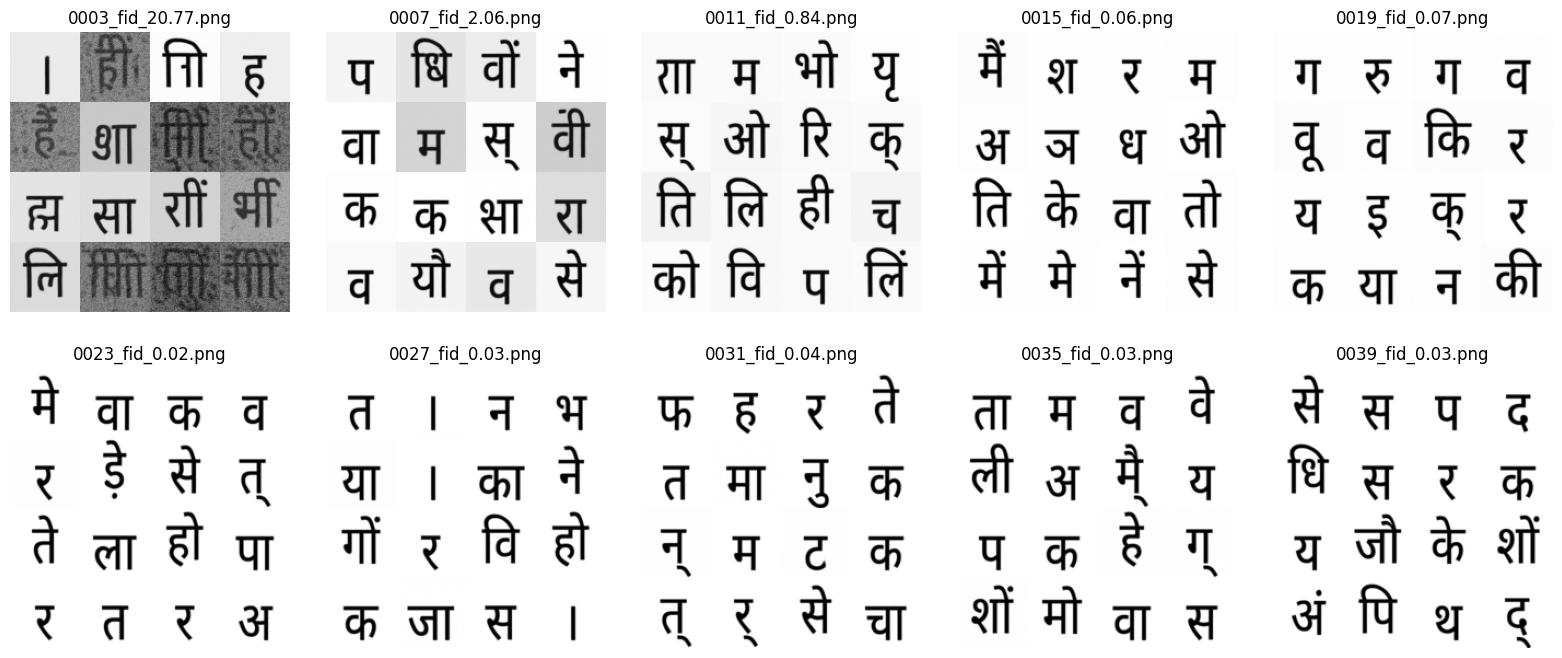

In [28]:
folder = "/kaggle/working/diffusion_50/samples"
images = sorted(glob.glob(f"{folder}/*.png"))
 
plt.figure(figsize=(20, 8)) 
plt.subplots_adjust(wspace=0.1, hspace=0.2) 

for i, img_path in enumerate(images):
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1) 
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12) 
    plt.axis("off")

plt.show()